In [12]:
import os
import torch
from torch import optim, nn, utils
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L

In [13]:
class ImageClassifier(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x) # Forward pass
        loss = self.loss_fn(logits, y)    
        self.log('train_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # compute accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_acc', acc)
        
    
# init the model
model = ImageClassifier()

In [8]:
# init the dataset
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

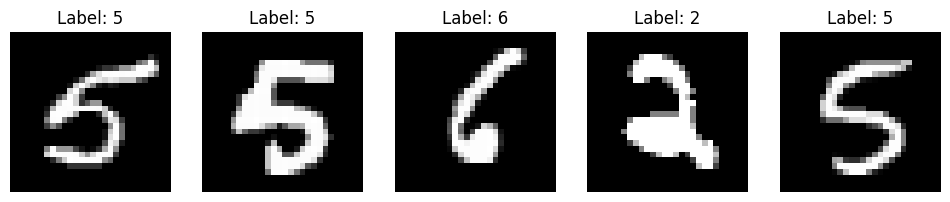

In [9]:
# sample and draw 5 data points
import matplotlib.pyplot as plt
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()


In [10]:
# train the model
trainer = L.Trainer(
    devices=[0],
    accelerator="gpu",
    max_epochs=5)

trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 101 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1875/1875 [00:13<00:00, 135.09it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1875/1875 [00:13<00:00, 135.03it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 1875/1875 [00:07<00:00, 236.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.12550000846385956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


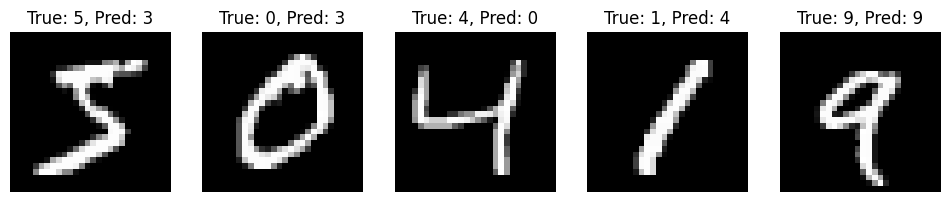

In [15]:
# test the model
trainer.test(model, dataloaders=test_loader)

# plot 5 test results
data_iter = iter(test_loader)
images, labels = next(data_iter)
logits = model(images)
preds = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
    axes[i].axis('off')
plt.show()
